<a href="https://colab.research.google.com/github/AnastasiaBrinati/Progetto-ML-23-24/blob/main/task1_centralizzato.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LeakyReLU, PReLU
import numpy as np
from keras.initializers import RandomNormal, he_normal, glorot_normal, he_uniform, glorot_uniform
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

In [ ]:
# Inizializza il seed per NumPy per riproducibilità
np.random.seed(42)

# Inizializza il seed per TensorFlow per riproducibilità
tf.random.set_seed(42)

# Caricamento del dataframe
df_train = pd.read_csv('/content/drive/MyDrive/customer_churn_dataset-training-master.csv')
df_test = pd.read_csv('/content/drive/MyDrive/customer_churn_dataset-testing-master.csv')
df = pd.concat([df_train, df_test])
df.info()

# Binning age
bins=[18,25,35,50,60,70,100]
df['Age_binned'] = pd.cut(df['Age'], bins)
df = df.drop(['Age','CustomerID'],axis=1)
df

import seaborn as sns
import matplotlib.pyplot as plt

# Calcola la matrice di correlazione
correlation_matrix = df.corr()

# Crea una heatmap della matrice di correlazione
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matrice di Correlazione')
plt.show()

# Define categorical and numerical features
numeric_features = ['Tenure','Support Calls','Payment Delay','Usage Frequency','Total Spend',	'Last Interaction']
categorical_features = ['Age_binned','Contract Length','Gender',	'Subscription Type']

# Divide dataset in features (X) and target (y)
X = df.drop(columns=['Churn'])
y = df['Churn']

# Encoding target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Divide dataset in training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Define transformers
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Gestione dei dati mancanti
    ('scaler', StandardScaler()),  # Normalizzazione delle feature numeriche
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder()),  # Encoding delle variabili categoriche
    ('imputer', SimpleImputer(strategy='most_frequent'))  # Gestione dei dati mancanti
])

# Define preprocessor for categorical and numeric features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Processing of data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

import pandas as pd

# Ottieni l'elenco delle colonne numeriche dopo la trasformazione
numeric_features_transformed = preprocessor.named_transformers_['num'].named_steps['scaler'].get_feature_names_out(numeric_features)

# Ottieni l'elenco delle colonne categoriche dopo la trasformazione
categorical_features_transformed = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)

# Unisci i due elenchi di colonne
feature_names = list(numeric_features_transformed) + list(categorical_features_transformed)

# Costruisci dataframe preprocessati per il set di addestramento
X_train_processed_df = pd.DataFrame(X_train_processed, columns=feature_names)

# Costruisci dataframe preprocessati per il set di test
X_test_processed_df = pd.DataFrame(X_test_processed, columns=feature_names)

# Ora X_train_processed_df e X_test_processed_df sono dataframe pandas preprocessati
X_train_processed_df

# Concatenazione delle feature preprocessate con le etichette per il training set
df_train_processed = pd.concat([X_train_processed_df, pd.DataFrame({'Churn': y_train})], axis=1)

# Concatenazione delle feature preprocessate con le etichette per il test set
df_test_processed = pd.concat([X_test_processed_df, pd.DataFrame({'Churn': y_test})], axis=1)

# Salva il training set preprocessato completo in un file CSV
df_train_processed.to_csv('/content/drive/MyDrive/train.csv', index=False)

# Salva il test set preprocessato completo in un file CSV
df_test_processed.to_csv('/content/drive/MyDrive/test.csv', index=False)


In [3]:
def model_builder(hp):
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(28, 28)))

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  model.add(keras.layers.Dense(units=hp_units, activation='relu'))
  model.add(keras.layers.Dense(10))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  return model

In [4]:
!pip install -q -U keras-tuner

import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, PReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import he_normal, glorot_normal

def model_builder(hp):
    model = Sequential()

    # Tune the number of units and activation function for each Dense layer
    for i in range(hp.Int('num_layers', 2, 5, default=3)):
        hp_units = hp.Int(f'units_{i}', min_value=16, max_value=128, step=16)
        hp_activation = hp.Choice(f'activation_{i}', values=['PReLU','LeakyReLU','relu', 'tanh', 'sigmoid'])

        model.add(Dense(units=hp_units, activation=hp_activation, kernel_initializer=he_normal))

    # Output layer
    model.add(Dense(1, activation='sigmoid', kernel_initializer=glorot_normal))

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='multi_layer_tuning')

stop_early = EarlyStopping(monitor='val_loss', patience=5)

tuner.search(X_train_processed, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of layers is {best_hps.get('num_layers')}.
""")

# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train_processed, y_train, epochs=30, validation_split=0.2)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch:', best_epoch)


Trial 30 Complete [00h 04m 24s]
val_accuracy: 0.9270594716072083

Best val_accuracy So Far: 0.9335790872573853
Total elapsed time: 01h 04m 55s

The hyperparameter search is complete. The optimal number of layers is 3.

Epoch 1/30
10105/10105 [==============================] - 30s 3ms/step - loss: 0.2360 - accuracy: 0.9206 - val_loss: 0.2165 - val_accuracy: 0.9276
Epoch 2/30
10105/10105 [==============================] - 31s 3ms/step - loss: 0.2145 - accuracy: 0.9278 - val_loss: 0.2080 - val_accuracy: 0.9304
Epoch 3/30
10105/10105 [==============================] - 30s 3ms/step - loss: 0.2087 - accuracy: 0.9292 - val_loss: 0.2025 - val_accuracy: 0.9308
Epoch 4/30
10105/10105 [==============================] - 29s 3ms/step - loss: 0.2042 - accuracy: 0.9295 - val_loss: 0.1980 - val_accuracy: 0.9321
Epoch 5/30
10105/10105 [==============================] - 30s 3ms/step - loss: 0.2012 - accuracy: 0.9301 - val_loss: 0.2013 - val_accuracy: 0.9322
Epoch 6/30
10105/10105 [======================

In [5]:
best_hps.values

{'num_layers': 3,
 'units_0': 128,
 'activation_0': 'PReLU',
 'units_1': 128,
 'activation_1': 'tanh',
 'units_2': 80,
 'activation_2': 'PReLU',
 'learning_rate': 0.001,
 'units_3': 48,
 'activation_3': 'sigmoid',
 'units_4': 112,
 'activation_4': 'sigmoid',
 'tuner/epochs': 10,
 'tuner/initial_epoch': 4,
 'tuner/bracket': 1,
 'tuner/round': 1,
 'tuner/trial_id': '0018'}

In [ ]:
# Retrain the model
hypermodel = tuner.hypermodel.build(best_hps)
history = hypermodel.fit(X_train_processed, y_train, epochs=best_epoch, validation_split=0.2)

# Evaluate the model on the test set
eval_result = hypermodel.evaluate(X_test_processed, y_test)
print("[test loss, test accuracy]:", eval_result)

Epoch 1/16
 2495/10105 [======>.......................] - ETA: 33s - loss: 0.2638 - accuracy: 0.9096

3158/3158 [==============================] - 7s 2ms/step - loss: 0.2000 - accuracy: 0.9303
Test accuracy: 0.9302963018417358


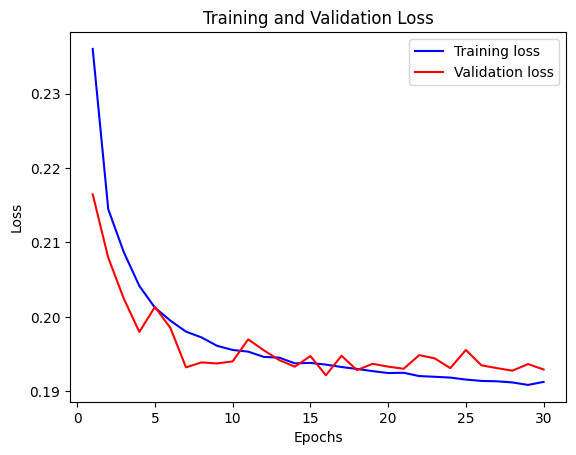

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               3200      
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dense_5 (Dense)             (None, 80)                10400     
                                                                 
 dense_6 (Dense)             (None, 1)                 81        
                                                                 
Total params: 30193 (117.94 KB)
Trainable params: 30193 (117.94 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [6]:
# Model evaluation
test_loss, test_accuracy = model.evaluate(X_test_processed, y_test)
print('Test accuracy:', test_accuracy)

# Estrai i valori di loss di training e validazione dal dizionario history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Crea un grafico per visualizzare l'andamento della loss durante l'addestramento
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
model.summary()

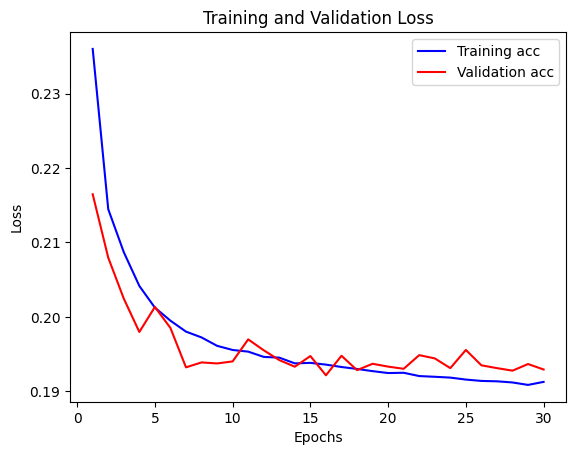

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               3200      
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dense_5 (Dense)             (None, 80)                10400     
                                                                 
 dense_6 (Dense)             (None, 1)                 81        
                                                                 
Total params: 30193 (117.94 KB)
Trainable params: 30193 (117.94 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [7]:
# Crea un grafico per visualizzare l'andamento della loss durante l'addestramento
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'b', label='Training acc')
plt.plot(epochs, val_loss, 'r', label='Validation acc')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
model.summary()

3158/3158 [==============================] - 7s 2ms/step


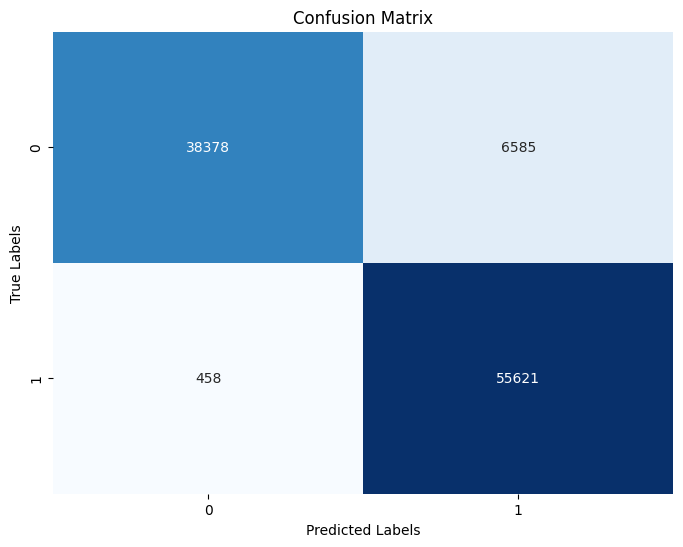

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predici le probabilità delle classi target sul set di test
y_pred_prob = model.predict(X_test_processed)

# Arrotonda le probabilità per ottenere le classi predette (0 o 1)
y_pred = (y_pred_prob > 0.5).astype(int)


# Calcola la confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualizza la confusion matrix utilizzando seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()
